In [1]:
import numpy as np
import torch
from itertools import product
from scipy import stats
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

TODO List:
- Added a convergence criterion for cases with explicit weight decay regularization.
- Added the `Groups` class which can handle imbalance sampling from groups.

In [31]:
# Linear regression
num_samples = 100       # per group (total = num_samples * num_groups)
num_features = 700
num_groups = 3

np.random.seed(42)
noise_level = 0.1
true_beta = np.random.randn( num_features, 1 ) # does not include the identifier weight.

In [32]:
def fully_structured_covariance(d):
    return np.diag( np.random.uniform(0.3, 4, size = d) ** 2 )

def identity_covariance(d):
    return np.identity( d )

class Group:

    ID = 0

    def __init__(self, covariance_generator = lambda: identity_covariance(num_features) ):
        self.id = Group.ID + 1
        Group.ID += 1

        self.cov = covariance_generator()
        self.x_dist = stats.multivariate_normal( cov = self.cov )

        self.x = None
        self.y = None
    
    # Generates X (input vars) 
    def _generate_x(self, n_samples, ID = False , **kwargs):
        x = self.x_dist.rvs(size= n_samples, **kwargs)
        if ID:
            identifier = np.repeat( self.ID , repeats=n_samples)
            x = np.column_stack( (identifier, x))
        return x
    
    # Generates (X, y) pairs according to linear model
    def generate(self, n_samples, beta = true_beta):
        x = self._generate_x(n_samples)
        y = np.dot(x, beta) + noise_level * np.random.randn(n_samples, 1)
        self.data = [x, y]
    
    @property
    def data(self):
        return self.x, self.y
    
    @data.setter
    def data(self, value):
        x, y = value # unpack
        self.x = torch.tensor(x, dtype = torch.float32, requires_grad=False)
        self.y = torch.tensor(y, dtype = torch.float32, requires_grad=False)

# Create the data
cov_generator = lambda: fully_structured_covariance(num_features)
groups = [ Group(cov_generator) for _ in range(num_groups) ]

# TODO: by this data generating process, we have equal number of groups in the
# training data, all disjoint. should we change this up (vary # of samples/gp)?
Data = {}
for group in groups:
    group.generate(num_samples, beta=true_beta)

    def __init__(self, num_groups, cov_generator = identity_covariance):

        Group.ID = 0
        self.groups = [ Group(cov_generator) for _ in range(num_groups) ]

        weights = self.WEIGHT_HANDLER(size = num_groups)
        weights /= weights.sum()
        self.weights = weights

        self.x , self.y = None, None
          
    
    def __iter__(self):
        return self.groups.__iter__()
    
    def __getitem__(self, index):
        return self.groups[index]

    def generate(self, n_samples, beta = true_beta):

        for group in self.groups:
            # Determine number of samples for this group
            n_group = self._get_nsample(n_samples, group)

            # Create the data for that specific group
            x = group._generate_x(n_group)
            y = np.dot(x, beta) + noise_level * np.random.randn(n_group, 1)
            
            group.data = [x, y]
    
    def _get_nsample(self, n, group):
        weights = self.weights
        weights = (weights * n).astype(int)
        weights[-1] = n - weights[:-1].sum()
        return int(weights[group.id])

    
    @property
    def data(self):
        if self.x is None:
            self.x = torch.cat( [ group.x for group in self.groups ], dim = 0 )
            self.y = torch.cat( [ group.y for group in self.groups ], dim = 0 )
        return self.x, self.y

    @data.setter
    def data(self,value):
        raise AttributeError("Can't assign data to this object.")
    

In [60]:

class LinearModel(torch.nn.Module):

    def __init__(self, input_dimension, **kwargs) -> None:
        super(LinearModel, self).__init__()
        # Initialize at zero. 
        self.linear = torch.nn.Linear( input_dimension, 1, bias = False, **kwargs )
        self._initialize(0.0)
    
    @classmethod
    def from_numpy(cls, weights: np.ndarray):
        input_dimension = weights.size 
        obj = cls(input_dimension)
        obj._initialize( weights.resize( (1, -1) ) )
        return obj 
    
    @torch.no_grad()
    def _initialize(self, value):
        self.linear.weight.fill_(value)
        if self.linear.weight.grad is not None:
            self.linear.weight.grad.detach_()
            self.linear.weight.grad.zero_()
    
    # forward passes should NOT come from calling this directly!
    # i.e. model(x) instead of model.forward(x)
    def forward(self, x):
        out = self.linear(x)
        return out
    
    # by default, MSELoss divides by n, the size of sample
    def risk(self, x, y):
        loss = torch.nn.MSELoss()
        mse = loss( self(x) , y )
        return mse
    
# training loop (gradient descent on the balanaced risk: lmbd * std + dro)
def optimize_GD(model, X, Y, groups, trade_regularization = 0.1, beta_regularization = 0, max_iter = 5000, lr = 1e-3, weight_decay = 0.0):
    lmbd = torch.tensor([trade_regularization], requires_grad=False)
    eta = torch.tensor([beta_regularization], requires_grad=False)  # explicit regularizer for beta
    optimizer = torch.optim.SGD( params = model.parameters(), lr = lr, weight_decay = weight_decay )

    flag = True         # for convergence criterion (objective low enough)
    iteration = 0
    prev_params = model.linear.weight.data.numpy().copy()
    prev_objective = np.inf

    while flag and iteration < max_iter:
        optimizer.zero_grad()

        standard_risk = model.risk( X, Y )
        adversarial_risk = torch.max( torch.stack( [ model.risk(group.x, group.y) for group in groups ] ) )
        objective = lmbd * standard_risk + (1-lmbd) * adversarial_risk + eta * torch.norm(model.linear.weight)

        objective.backward()
        optimizer.step()

        # Check convergence based on parameter change. 
        relative_parameter_error = np.linalg.norm( prev_params - model.linear.weight.data.numpy() ) / np.linalg.norm( model.linear.weight.data.numpy() )
        relative_objective_error = np.abs( prev_objective - objective.item() ) 
        if relative_parameter_error < 1e-6 + weight_decay:
            flag = False
        
        if iteration % 100 == 0 and verbose:
            print(f" Objective loss is {objective.item():.4f} = {lmbd_std.item():.2f} * { standard_risk.item():.4f} + {lmbd_adv.item():.2f} * {adversarial_risk.item():.4f}")
            #print(f" Relative parameter error is {relative_parameter_error}")
        iteration += 1
        
        prev_params = model.linear.weight.data.numpy().copy()
        prev_objective = objective.item()
    
    # Final round printing
    if verbose:
        print(f" Objective loss is {objective.item():.4f} = {lmbd_std.item():.2f} * { standard_risk.item():.4f} + {lmbd_adv.item():.2f} * {adversarial_risk.item():.4f} at iteration {iteration}")
        print(f" Relative parameter error is {relative_parameter_error}")
    
    if iteration == max_iter:
        print("Maximum iteration reached.")

In [49]:
# Create the data
cov_generator = lambda: fully_structured_covariance(num_features)
groups = Groups(num_groups, cov_generator)

# TODO: by this data generating process, we have equal number of groups in the
# training data, all disjoint. should we change this up (vary # of samples/gp)?
groups.generate(num_samples, beta= true_beta)

X , Y = groups.data

# Solve the weighted regression problem using vanilla GD
lmbd = torch.tensor([0.1], requires_grad=False)
max_iter = 2000

model = LinearModel(num_features)
optimize_GD(model, X, Y, groups, trade_regularization = 1e2, weight_decay=1e-5, lr=1e-3, max_iter= max_iter, verbose=True)

 Objective loss is 4500.2612 = 0.01 * 3891.0300 + 1.00 * 4461.3511
 Objective loss is 84.2764 = 0.01 * 79.0548 + 1.00 * 83.4859
 Objective loss is 16.2407 = 0.01 * 15.1991 + 1.00 * 16.0887
 Objective loss is 4.5288 = 0.01 * 4.2983 + 1.00 * 4.4859
 Objective loss is 1.5201 = 0.01 * 1.4442 + 1.00 * 1.5056
 Objective loss is 0.5754 = 0.01 * 0.5416 + 1.00 * 0.5700
 Objective loss is 0.2334 = 0.01 * 0.2205 + 1.00 * 0.2312
 Objective loss is 0.1017 = 0.01 * 0.0951 + 1.00 * 0.1007
 Objective loss is 0.0453 = 0.01 * 0.0427 + 1.00 * 0.0449
 Objective loss is 0.0219 = 0.01 * 0.0202 + 1.00 * 0.0217
 Objective loss is 0.0101 = 0.01 * 0.0097 + 1.00 * 0.0100
 Objective loss is 0.0050 = 0.01 * 0.0048 + 1.00 * 0.0049
 Objective loss is 0.0025 = 0.01 * 0.0024 + 1.00 * 0.0025
 Objective loss is 0.0013 = 0.01 * 0.0012 + 1.00 * 0.0012
 Objective loss is 0.0007 = 0.01 * 0.0006 + 1.00 * 0.0007
 Objective loss is 0.0005 = 0.01 * 0.0005 + 1.00 * 0.0005 at iteration 1432
 Relative parameter error is 1.06494153

In [50]:
# OLS
ols_beta = torch.linalg.lstsq( X, Y ).solution

# Subgroups- OLS
subgroup_beta = [ torch.linalg.lstsq( group.x, group.y ).solution for group in groups ]

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

betas = np.hstack( [model.linear.weight.data.numpy().T, ols_beta.data.numpy()] + [beta.data.numpy() for beta in subgroup_beta ] )
betas = pd.DataFrame( betas, columns=["model", "OLS"] + [f"Group {i} OLS" for i in range(num_groups)] )

In [52]:
betas.corr()

true_beta     model       OLS  Group 0 OLS  Group 1 OLS  \
true_beta     1.000000  0.647591  0.647592     0.372726     0.412482   
model         0.647591  1.000000  0.999999     0.575383     0.637500   
OLS           0.647592  0.999999  1.000000     0.575317     0.637424   
Group 0 OLS   0.372726  0.575383  0.575317     1.000000     0.108200   
Group 1 OLS   0.412482  0.637500  0.637424     0.108200     1.000000   
Group 2 OLS   0.319673  0.493764  0.493708     0.105641     0.114303   

             Group 2 OLS  
true_beta       0.319673  
model           0.493764  
OLS             0.493708  
Group 0 OLS     0.105641  
Group 1 OLS     0.114303  
Group 2 OLS     1.000000

## Experiment 1: Varying $\lambda$ Tradeoff Parameter
Our notion of tradeoff risk between DRO and standard risk is controlled by the parameter $\lambda$. Fully writing out the
tradeoff objective, we have:
$$
\mathcal{R}_{\mathrm{trade}}(\beta; \lambda) := \mathcal{R}_{\mathrm{group}}(\beta) + \lambda \mathcal{R}_{\mathrm{std}}(\beta)
= \max_{g \in \mathcal{G}} \mathbb{E}_{(X, Y) \sim \mathbb{P}_g}[(X^\top \beta - Y)^2] + \lambda \mathbb{E}_{X \sim \mathbb{P}_X}\left[ \mathbb{E} \left[ (X^\top \beta - Y)^2 \mid X \right] \right],
$$
where $\mathbb{P}_g$ is the group distribution for group $g \in \mathcal{G}$. The $\lambda$ parameter controls how much we tradeoff for standard risk in our objective. $\lambda = 0$ means we are solely optimizing for group DRO. We vary the value of $\lambda$ and see if this has any effect on the resulting $\hat{\beta}$ that our model produces by minimizing $\hat{\mathcal{R}}_{\mathrm{trade}}$


In [53]:
import matplotlib.pyplot as plt

max_iter = 2000
lambdas = torch.tensor(np.linspace(0, 1.0), requires_grad=False)
ols_beta = torch.linalg.lstsq( X, Y ).solution  # regular OLS solution
subgroup_betas = [ torch.linalg.lstsq( group.x, group.y ).solution for group in groups ] # OLS for each group
model_betas = list()

for lmbd in lambdas:
    # train tradeoff model
    model = LinearModel(num_features)
    optimize_GD(model, X, Y, groups, trade_regularization = lmbd, lr = 1e-3,max_iter= max_iter, verbose=True)
    model_betas.append(model.linear.weight.data.numpy().T)

 Objective loss is 3891.0746 = 1.00 * 3891.0300 + 0.00 * 4461.3511
 Objective loss is 84.4963 = 1.00 * 84.4954 + 0.00 * 89.5884
 Objective loss is 16.7031 = 1.00 * 16.7030 + 0.00 * 18.3191
 Objective loss is 4.8310 = 1.00 * 4.8309 + 0.00 * 5.3672
 Objective loss is 1.6616 = 1.00 * 1.6616 + 0.00 * 1.8425
 Objective loss is 0.6372 = 1.00 * 0.6372 + 0.00 * 0.7396
 Objective loss is 0.2647 = 1.00 * 0.2647 + 0.00 * 0.3243
 Objective loss is 0.1170 = 1.00 * 0.1170 + 0.00 * 0.1488
 Objective loss is 0.0543 = 1.00 * 0.0543 + 0.00 * 0.0706
 Objective loss is 0.0262 = 1.00 * 0.0262 + 0.00 * 0.0344
 Objective loss is 0.0130 = 1.00 * 0.0130 + 0.00 * 0.0171
 Objective loss is 0.0066 = 1.00 * 0.0066 + 0.00 * 0.0086
 Objective loss is 0.0034 = 1.00 * 0.0034 + 0.00 * 0.0044
 Objective loss is 0.0018 = 1.00 * 0.0018 + 0.00 * 0.0023
 Objective loss is 0.0009 = 1.00 * 0.0009 + 0.00 * 0.0012
 Objective loss is 0.0005 = 1.00 * 0.0005 + 0.00 * 0.0006
 Objective loss is 0.0003 = 1.00 * 0.0003 + 0.00 * 0.0003

Text(0, 0.5, '$\\frac{\\| \\beta_{\\mathrm{trade}} - \\beta_{\\mathrm{OLS}} \\|_2}{ \\| \\beta_{\\mathrm{OLS}} \\|_2 }$')

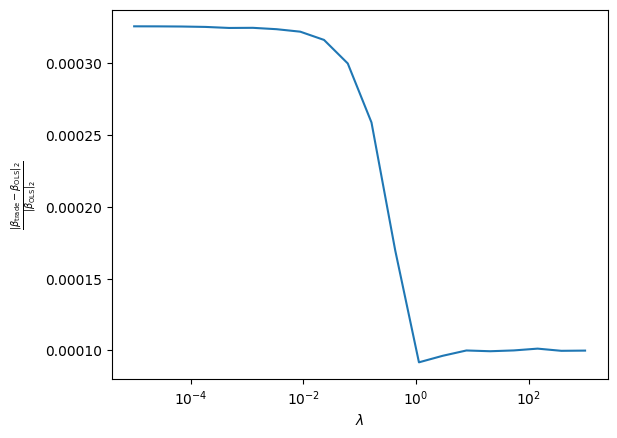

In [54]:
# Plot difference between model's betas and OLS beta
# Is this actually a significant difference?
beta_l2 = [np.linalg.norm(model_beta - ols_beta.numpy()) / np.linalg.norm(ols_beta.numpy()) for model_beta in model_betas]
plt.plot(lambdas, beta_l2)
plt.xscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\frac{\| \beta_{\mathrm{trade}} - \beta_{\mathrm{OLS}} \|_2}{ \| \beta_{\mathrm{OLS}} \|_2 }$')

Upshot: **they're the same!**

## Experiment 2: Adding Explicit Regularizer ($\eta\|\beta\|^2$) for different $\lambda$
Now, we add an explicit $\ell_2$ regularization to the objective, controlled by $\eta > 0.$ This gives us the objective:
$$
\mathcal{R}_{\mathrm{trade}}(\beta; \lambda; \eta)
= (1 - \lambda) \max_{g \in \mathcal{G}} \mathbb{E}_{(X, Y) \sim \mathbb{P}_g}[(X^\top \beta - Y)^2] + \lambda \mathbb{E}_{X \sim \mathbb{P}_X}\left[ \mathbb{E} \left[ (X^\top \beta - Y)^2 \mid X \right] \right] + \eta\|\beta\|_2,
$$
where we vary $\lambda \in [0, 1]$. Again, we denote the $\beta$ that we get from running GD on $\mathcal{R}_{\mathrm{trade}}(\beta; \lambda)$ as $\beta_{\mathrm{trade}}$. We denote the OLS solution as $\beta_{\mathrm{OLS}}$. For $\lambda = 1$, the $\mathcal{R}_{\mathrm{trade}}$ objective is equivalent to ridge regression, which we also compare to for the same values of $\eta$.

In [55]:
max_iter = np.inf
etas = np.logspace(-5,2, 20)
model_betas = list()

# Fix lambda regularizer to 0.1, vary lambdas
for eta in tqdm(etas):
    # train tradeoff model
    model = LinearModel(num_features)
    optimize_GD(model, X , Y, groups, trade_regularization = 0.1, weight_decay = eta, max_iter= max_iter)
    model_betas.append(model.linear.weight.data.numpy().T)

100%|██████████| 20/20 [00:02<00:00,  7.99it/s]


Text(0, 0.5, '$\\frac{\\| \\beta_{\\mathrm{trade}} - \\beta_{\\mathrm{OLS}} \\|_2}{ \\| \\beta_{\\mathrm{OLS}} \\|_2 }$')

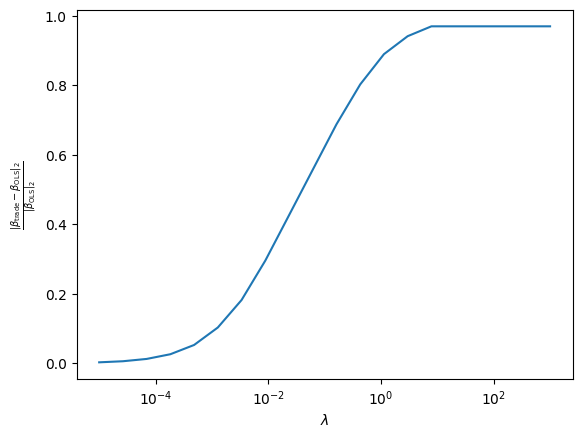

In [56]:
# Plot difference between model's betas and OLS beta
# Is this actually a significant difference?
beta_l2 = [np.linalg.norm(model_beta - ols_beta.numpy()) / np.linalg.norm(ols_beta.numpy()) for model_beta in model_betas]
plt.plot(lambdas, beta_l2)
plt.xscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\frac{\| \beta_{\mathrm{trade}} - \beta_{\mathrm{OLS}} \|_2}{ \| \beta_{\mathrm{OLS}} \|_2 }$')

Text(0, 0.5, '$\\frac{\\| \\beta_{\\mathrm{trade}} - \\beta_* \\|_2}{ \\| \\beta_* \\|_2 }$')

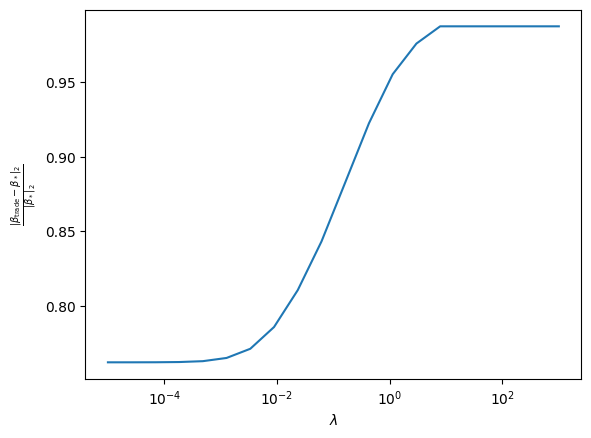

In [57]:
# Plot difference between model's betas and OLS beta
# Is this actually a significant difference?
beta_l2 = [np.linalg.norm(model_beta - true_beta) / np.linalg.norm(true_beta) for model_beta in model_betas]
plt.plot(lambdas, beta_l2)
plt.xscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\frac{\| \beta_{\mathrm{trade}} - \beta_* \|_2}{ \| \beta_* \|_2 }$')

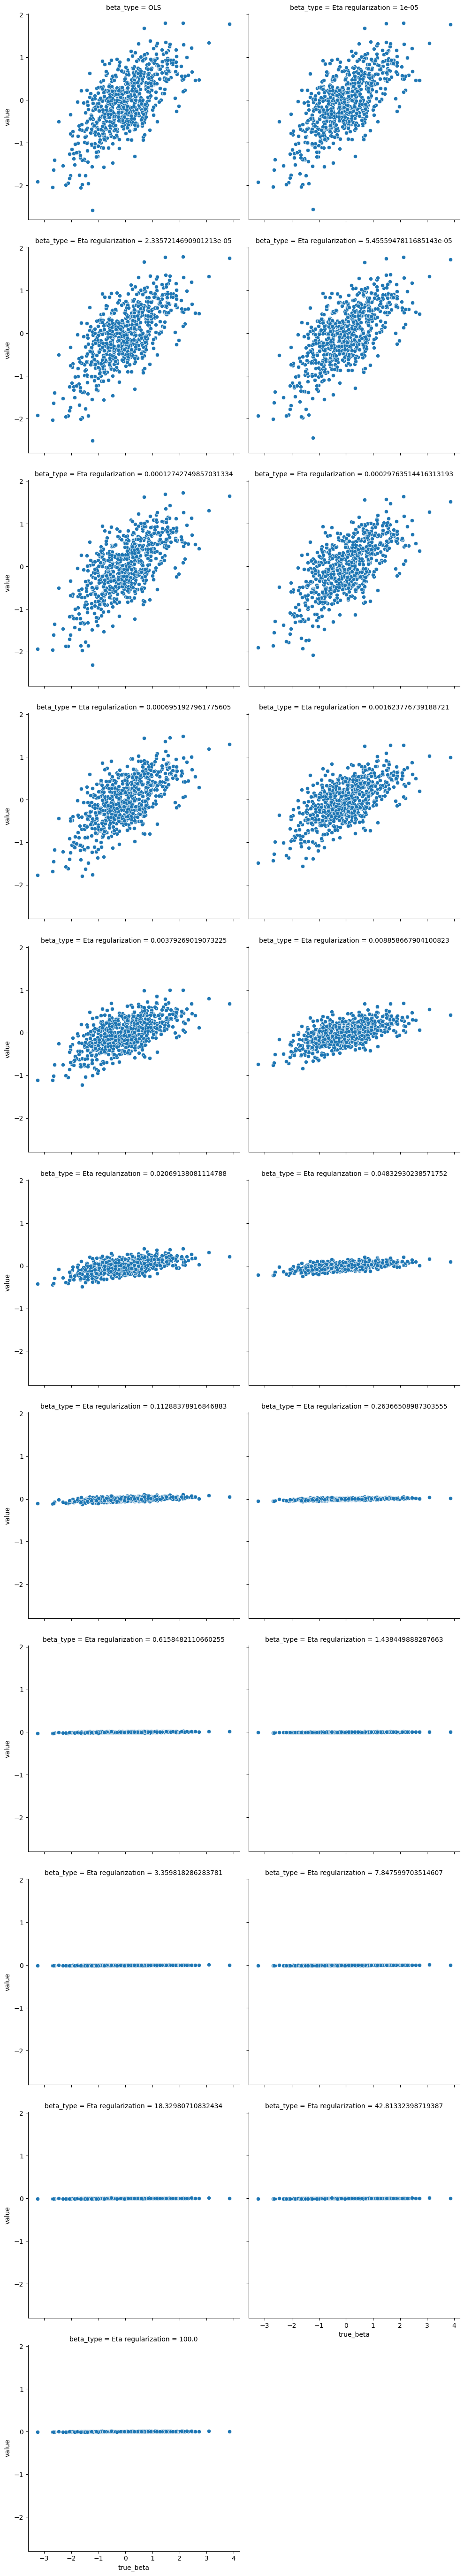

In [46]:
betas = np.hstack( [true_beta, ols_beta.data.numpy()] + model_betas )
betas = pd.DataFrame( betas, columns=["true_beta", "OLS"] + [f"Eta regularization = {eta}" for eta in etas] )
beta_melt = betas.melt( id_vars = ["true_beta"], value_vars= betas.columns[1:], var_name="beta_type" )

sns.relplot(data = beta_melt, x = "true_beta", y = "value", col = "beta_type", col_wrap=2)
#sns.scatterplot( data = betas.set_index("true_beta"))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left")


In [27]:
betas.corr()[["true_beta","OLS"]]

,true_beta,OLS
true_beta,1.000000,0.661824
OLS,0.661824,1.000000
Eta regularization = 1e-05,0.661822,0.999990
Eta regularization = 2.3357214690901213e-05,0.661804,0.999959
Eta regularization = 5.4555947811685143e-05,0.661719,0.999820
Eta regularization = 0.00012742749857031334,0.661344,0.999238
Eta regularization = 0.00029763514416313193,0.659855,0.996960
Eta regularization = 0.0006951927961775605,0.654856,0.989335
Eta regularization = 0.001623776739188721,0.642737,0.970875
Eta regularization = 0.00379269019073225,0.621724,0.938908
